Download the data - after extracting features through a processing block - so we can train a machine learning model.

In [1]:
import numpy as np
import requests
import pandas as pd
import os, time, warnings
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
import logging
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, 
    LSTM, 
    InputLayer, 
    Dropout, 
    Conv1D, 
    Conv2D, 
    Flatten,
    Reshape,
    MaxPooling1D, 
    MaxPooling2D, 
    BatchNormalization, 
    TimeDistributed)

from tensorflow.keras.optimizers import Adam

# visualize model architecture
import visualkeras
from PIL import ImageFont
from tensorflow.keras.utils import plot_model

warnings.filterwarnings("ignore")

In [2]:
log_cols = ["model", "accuracy", "train_time", "pred_time"]
log = pd.DataFrame(columns=log_cols)

In [3]:
API_KEY = 'ei_b8a8b4d0e888f91b15b49d8259017cf947bf6a583d68f079903e1b61251990a1'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/89974/training/90/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/89974/training/90/y')

Store the data in a temporary file, and load it back through Numpy.

In [4]:
with open('dataset/x_train_mfe.npy', 'wb') as file:
    file.write(X)
with open('dataset/y_train_mfe.npy', 'wb') as file:
    file.write(Y)

In [5]:
# load numpy
X = np.load('dataset/x_train_mfe.npy')
Y = np.load('dataset/y_train_mfe.npy')[:,0]

Define our labels and split the data up in a test and training set:

In [6]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "danger_alarm", "fire_alarm", "gas_alarm", "non_alarm", "tsunami_alarm" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


In [7]:
X.shape

(4446, 2440)

In [8]:
validation_dataset_CNN1D = validation_dataset
train_dataset_CNN1D = train_dataset

In [9]:
validation_dataset_CNN2D = validation_dataset
train_dataset_CNN2D = train_dataset

## Train With Conv 1D:

In [10]:
# model architecture
CNN1D_model = Sequential()
CNN1D_model.add(Reshape((int(input_length / 40), 40), input_shape=(input_length, )))
CNN1D_model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same'))
CNN1D_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
CNN1D_model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
CNN1D_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
CNN1D_model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
CNN1D_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
CNN1D_model.add(Flatten())
CNN1D_model.add(Dropout(0.5))
CNN1D_model.add(Dense(64, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))
CNN1D_model.add(Dropout(0.5))
CNN1D_model.add(Dense(classes, activation='softmax', name='y_pred'))

CNN1D_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 61, 40)            0         
                                                                 
 conv1d (Conv1D)             (None, 61, 16)            1936      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 31, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 32)            1568      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 16, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 16, 64)            6

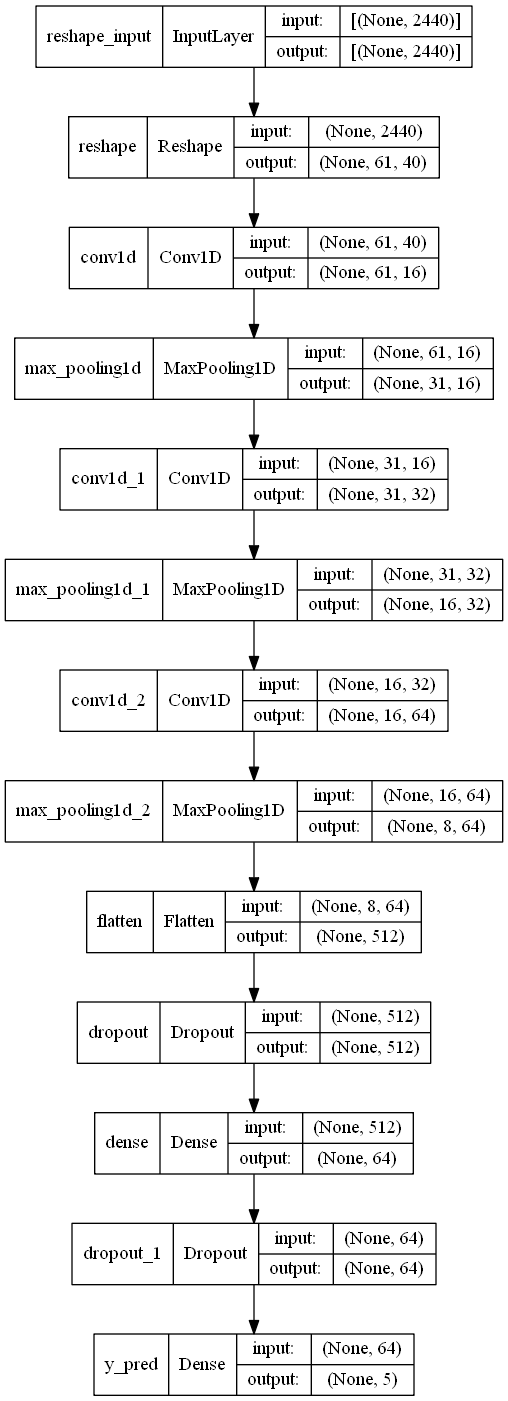

In [11]:
#plot model deep learning
plot_model(CNN1D_model, to_file="model/model-conv1D-architecture.png", show_shapes=True)

In [12]:
# this controls the learning rate
opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
EPOCHS = 200
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset_CNN1D = train_dataset_CNN1D.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset_CNN1D = validation_dataset_CNN1D.batch(BATCH_SIZE, drop_remainder=False)

In [13]:
filename='log/log_mfe_CNN1D.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [14]:
from datetime import datetime

# time calculation
start = datetime.now()
t0 = time.time()

# train the neural network
CNN1D_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history_CNN1D = CNN1D_model.fit(train_dataset_CNN1D, epochs=EPOCHS, validation_data=validation_dataset_CNN1D, verbose=2, callbacks=[history_logger])

train_hist_m1 = pd.DataFrame(history_CNN1D.history)

train_m1 = round(time.time() - t0, 3)
duration = datetime.now() - start
print("Training completed in time: ", duration)


Epoch 1/200
112/112 - 2s - loss: 1.2670 - accuracy: 0.4379 - val_loss: 1.1104 - val_accuracy: 0.5719 - 2s/epoch - 22ms/step
Epoch 2/200
112/112 - 1s - loss: 0.9154 - accuracy: 0.6066 - val_loss: 0.8189 - val_accuracy: 0.6011 - 832ms/epoch - 7ms/step
Epoch 3/200
112/112 - 1s - loss: 0.7301 - accuracy: 0.6969 - val_loss: 0.5870 - val_accuracy: 0.7348 - 751ms/epoch - 7ms/step
Epoch 4/200
112/112 - 1s - loss: 0.6456 - accuracy: 0.7334 - val_loss: 0.5364 - val_accuracy: 0.8112 - 816ms/epoch - 7ms/step
Epoch 5/200
112/112 - 1s - loss: 0.5707 - accuracy: 0.7905 - val_loss: 0.6326 - val_accuracy: 0.7124 - 977ms/epoch - 9ms/step
Epoch 6/200
112/112 - 1s - loss: 0.5604 - accuracy: 0.7899 - val_loss: 0.5393 - val_accuracy: 0.8056 - 707ms/epoch - 6ms/step
Epoch 7/200
112/112 - 1s - loss: 0.5005 - accuracy: 0.8113 - val_loss: 0.3496 - val_accuracy: 0.8910 - 824ms/epoch - 7ms/step
Epoch 8/200
112/112 - 1s - loss: 0.4936 - accuracy: 0.8200 - val_loss: 0.3974 - val_accuracy: 0.8506 - 708ms/epoch - 6ms

In [15]:
# save Model
CNN1D_model.save("model/CNN1D_model.h5")
print("CNN1D Model Saved")

CNN1D Model Saved


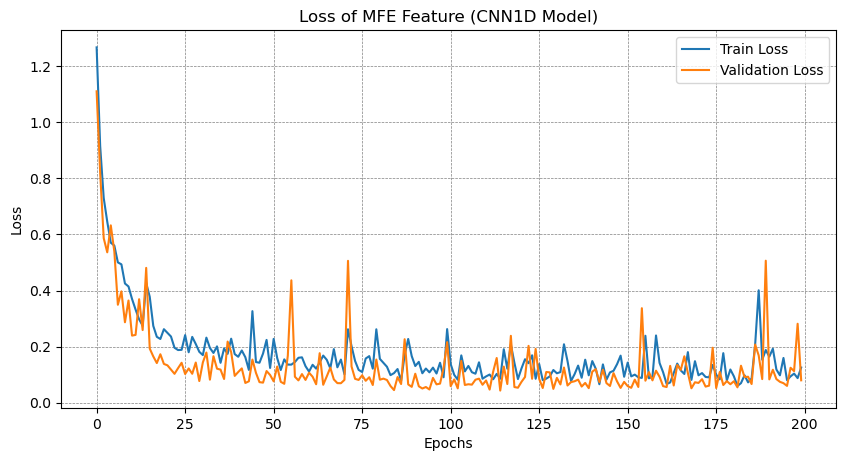

In [16]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_hist_m1[["loss", "val_loss"]])
plt.legend(["Train Loss", "Validation Loss"])
plt.title("Loss of MFE Feature (CNN1D Model)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()

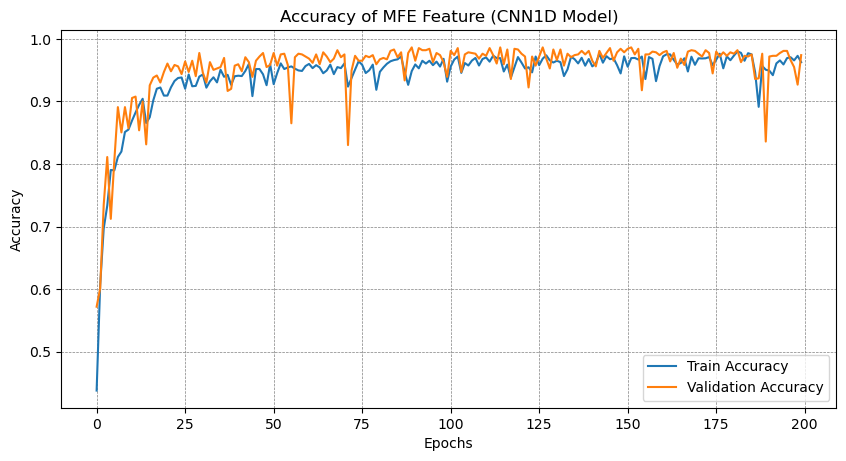

In [17]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_hist_m1[["accuracy", "val_accuracy"]])
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.title("Accuracy of MFE Feature (CNN1D Model)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()

In [18]:
acc_m1 = CNN1D_model.evaluate(X_test, Y_test, verbose=0)
t0 = time.time()
y_pred_m1 = CNN1D_model.predict(X_test, verbose=0)
pred_m1 = round(time.time() - t0, 3)

log_entry = pd.DataFrame(
    [["CNN1D", acc_m1[1] * 100, train_m1, pred_m1]], columns=log_cols
)
log = log.append(log_entry)

In [19]:
log

,model,accuracy,train_time,pred_time
0,CNN1D,97.415727,157.81,0.269


In [20]:
# train Accuracy and Loss
train_loss, train_acc = CNN1D_model.evaluate(X_train, Y_train, verbose=0)
print("train loss: {0:.6f}, train accuracy: {1:.6f}".format(train_loss, train_acc))

# Val Accuracy and Loss
val_loss, val_acc = CNN1D_model.evaluate(X_test, Y_test, verbose=0)
print("val loss: {0:.6f}, val accuracy: {1:.6f}".format(val_loss, val_acc))

train loss: 0.058430, train accuracy: 0.976940
val loss: 0.080286, val accuracy: 0.974157


In [21]:
# Extract samples and labels from validation set (which is batched)
X_val = np.concatenate([x for x, _ in validation_dataset_CNN1D], axis=0)
y_val = np.concatenate([y for _, y in validation_dataset_CNN1D], axis=0)

# Run inference on validation set
y_pred = np.argmax(CNN1D_model.predict(X_val), axis=1)

# Convert one-hot encoding to label encoding for ground-truth labels
y_true = np.argmax(y_val, axis=1)

def acc(y_true, y_pred):
    return np.equal(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1)).mean()

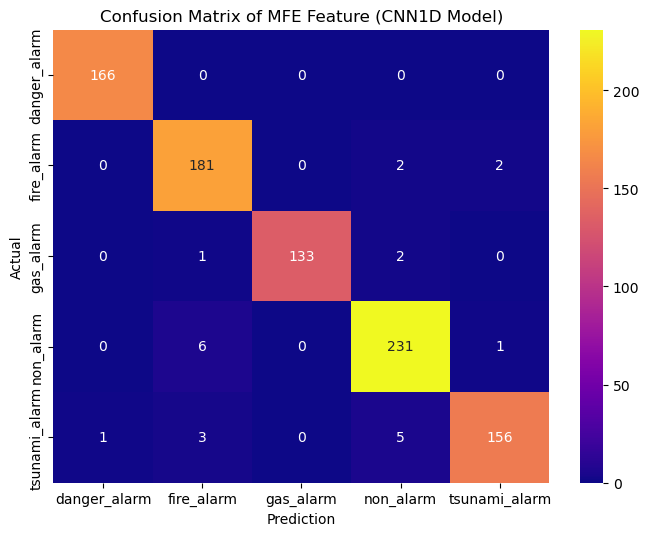

In [22]:
import seaborn as sns

# Labels from project
labels = ["danger_alarm", "fire_alarm", "gas_alarm", "non_alarm", "tsunami_alarm"]

# Show confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(confusion_mtx,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g', cmap="plasma")
plt.title("Confusion Matrix of MFE Feature (CNN1D Model)")
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

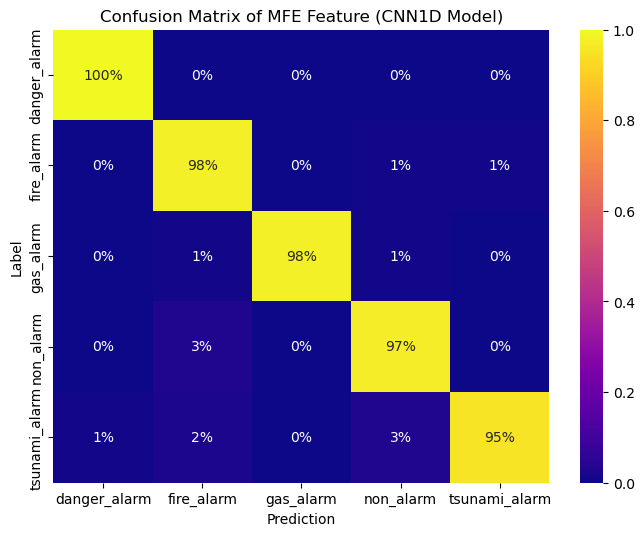

In [23]:
import seaborn as sns

# Labels from project
labels = ["danger_alarm", "fire_alarm", "gas_alarm", "non_alarm", "tsunami_alarm"]

# Show confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
cm_normalized=np.round(confusion_mtx/np.sum(confusion_mtx,axis=1).reshape(-1,1),2)
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(cm_normalized,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt=".0%", cmap="plasma")
plt.title("Confusion Matrix of MFE Feature (CNN1D Model)")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [24]:
from sklearn import metrics
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       166
           1       0.95      0.98      0.96       185
           2       1.00      0.98      0.99       136
           3       0.96      0.97      0.97       238
           4       0.98      0.95      0.96       165

    accuracy                           0.97       890
   macro avg       0.98      0.97      0.98       890
weighted avg       0.97      0.97      0.97       890



## Train Using Conv2D

In [25]:
# model architecture
CNN2D_model = Sequential()
channels = 1
columns = 40
rows = int(input_length / (columns * channels))
CNN2D_model.add(Reshape((rows, columns, channels), input_shape=(input_length, )))
#layer 1
CNN2D_model.add(Conv2D(8, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
CNN2D_model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
#layer 2
CNN2D_model.add(Conv2D(16, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
CNN2D_model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
#layer 3
CNN2D_model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
CNN2D_model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

#layer 4
#CNN2D_model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
#CNN2D_model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

# Fully Connected Layer
CNN2D_model.add(Flatten())
CNN2D_model.add(Dropout(0.5))
CNN2D_model.add(Dense(32, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))
CNN2D_model.add(Dropout(0.5))
CNN2D_model.add(Dense(classes, activation='softmax', name='y_pred'))
CNN2D_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 61, 40, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 61, 40, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 20, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 20, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 10, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 10, 32)       

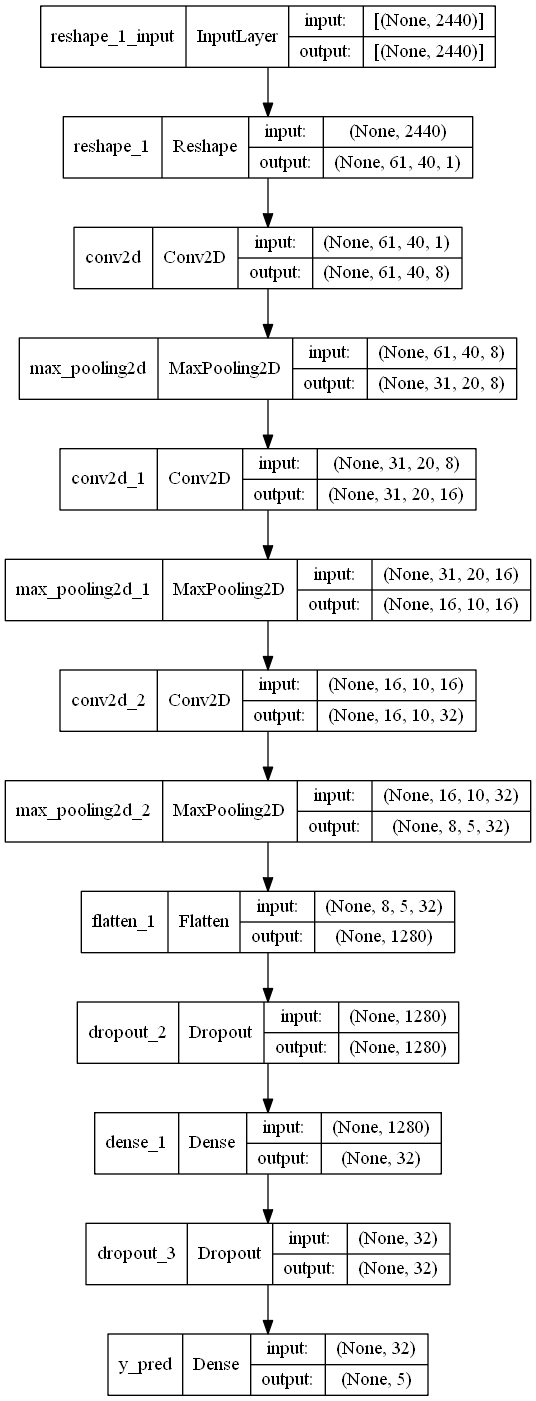

In [26]:
#plot model deep learning
plot_model(CNN2D_model, to_file="model/model-conv2D-architecture.png", show_shapes=True)

In [27]:
# this controls the learning rate
opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
EPOCHS = 200
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset_CNN2D = train_dataset_CNN2D.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset_CNN2D = validation_dataset_CNN2D.batch(BATCH_SIZE, drop_remainder=False)

In [28]:
filename='log/log_mfe_CNN2D.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [29]:
from datetime import datetime 
start = datetime.now()
t0 = time.time()

# train the neural network
CNN2D_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history_CNN2D = CNN2D_model.fit(train_dataset_CNN2D, epochs=EPOCHS, validation_data=validation_dataset_CNN2D, verbose=2, callbacks=[history_logger])
# Use this flag to disable per-channel quantization for a model.
# This can reduce RAM usage for convolutional models, but may have
# an impact on accuracy.
disable_per_channel_quantization = False

train_hist_m2 = pd.DataFrame(history_CNN2D.history)
train_m2 = round(time.time() - t0, 3)
duration = datetime.now() - start

print("Training completed in time: ", duration)


Epoch 1/200
112/112 - 3s - loss: 1.0654 - accuracy: 0.5624 - val_loss: 0.4590 - val_accuracy: 0.8337 - 3s/epoch - 31ms/step
Epoch 2/200
112/112 - 3s - loss: 0.5017 - accuracy: 0.8335 - val_loss: 0.1843 - val_accuracy: 0.9360 - 3s/epoch - 24ms/step
Epoch 3/200
112/112 - 3s - loss: 0.3649 - accuracy: 0.8791 - val_loss: 0.1415 - val_accuracy: 0.9539 - 3s/epoch - 24ms/step
Epoch 4/200
112/112 - 3s - loss: 0.2568 - accuracy: 0.9165 - val_loss: 0.1341 - val_accuracy: 0.9494 - 3s/epoch - 26ms/step
Epoch 5/200
112/112 - 3s - loss: 0.2226 - accuracy: 0.9272 - val_loss: 0.1387 - val_accuracy: 0.9449 - 3s/epoch - 26ms/step
Epoch 6/200
112/112 - 3s - loss: 0.2127 - accuracy: 0.9353 - val_loss: 0.1056 - val_accuracy: 0.9663 - 3s/epoch - 27ms/step
Epoch 7/200
112/112 - 3s - loss: 0.1994 - accuracy: 0.9350 - val_loss: 0.0877 - val_accuracy: 0.9742 - 3s/epoch - 26ms/step
Epoch 8/200
112/112 - 3s - loss: 0.1884 - accuracy: 0.9384 - val_loss: 0.0631 - val_accuracy: 0.9798 - 3s/epoch - 25ms/step
Epoch 9/

In [30]:
# Save the model to disk
CNN2D_model.save('model/saved_model_CNN2D')

In [31]:
# save Model
CNN2D_model.save("model/CNN2D_MFE_model.h5")
print("CNN2D Model Saved")

CNN2D Model Saved


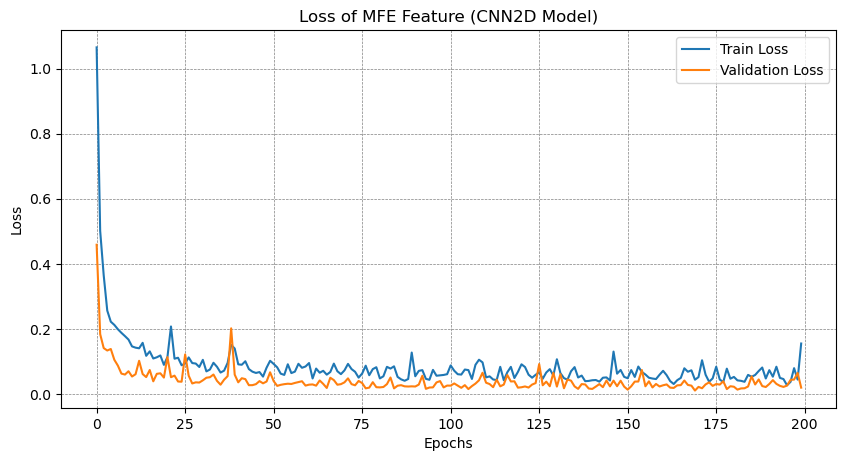

In [32]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_hist_m2[["loss", "val_loss"]])
plt.legend(["Train Loss", "Validation Loss"])
plt.title("Loss of MFE Feature (CNN2D Model)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()

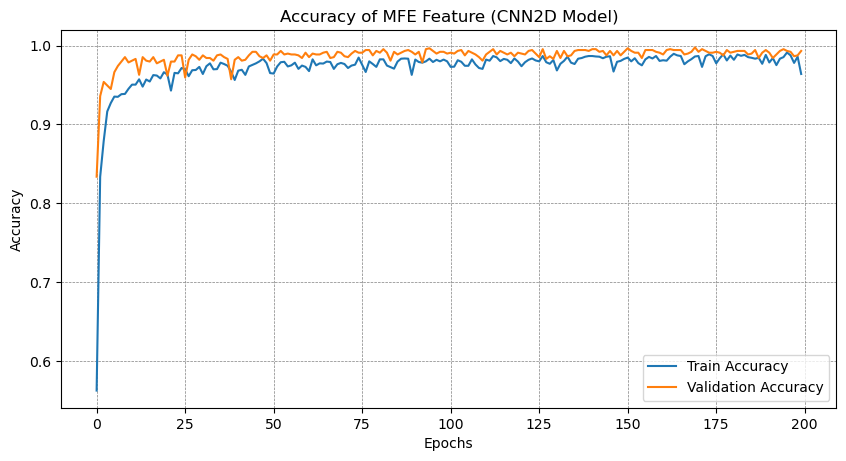

In [33]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_hist_m2[["accuracy", "val_accuracy"]])
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.title("Accuracy of MFE Feature (CNN2D Model)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()

In [34]:
acc_m2 = CNN2D_model.evaluate(X_test, Y_test, verbose=0)
t0 = time.time()
y_pred_m2 = CNN2D_model.predict(X_test, verbose=0)
pred_m2 = round(time.time() - t0, 3)
log_entry = pd.DataFrame(
    [["CNN2D", acc_m2[1] * 100, train_m2, pred_m2]], columns=log_cols
)
log = log.append(log_entry)

In [35]:
log

,model,accuracy,train_time,pred_time
0,CNN1D,97.415727,157.810,0.269
0,CNN2D,99.325842,586.415,0.309


In [36]:
# train Accuracy and Loss
train_loss, train_acc = CNN2D_model.evaluate(X_train, Y_train, verbose=0)
print("train loss: {0:.6f}, train accuracy: {1:.6f}".format(train_loss, train_acc))

# Val Accuracy and Loss
val_loss, val_acc = CNN2D_model.evaluate(X_test, Y_test, verbose=0)
print("val loss: {0:.6f}, val accuracy: {1:.6f}".format(val_loss, val_acc))

train loss: 0.010890, train accuracy: 0.997188
val loss: 0.019986, val accuracy: 0.993258


In [37]:
# Extract samples and labels from validation set (which is batched)
X_val = np.concatenate([x for x, _ in validation_dataset_CNN2D], axis=0)
y_val = np.concatenate([y for _, y in validation_dataset_CNN2D], axis=0)

# Run inference on validation set
y_pred = np.argmax(CNN2D_model.predict(X_val), axis=1)

# Convert one-hot encoding to label encoding for ground-truth labels
y_true = np.argmax(y_val, axis=1)

def acc(y_true, y_pred):
    return np.equal(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1)).mean()

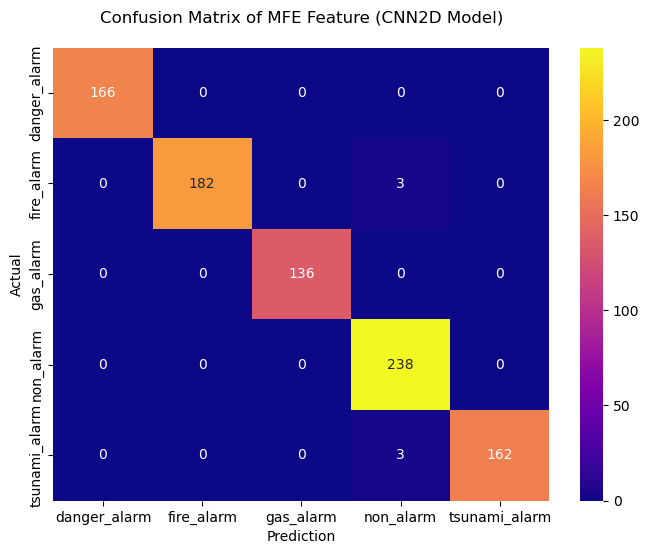

In [38]:
import seaborn as sns

# Labels from project
labels = ["danger_alarm", "fire_alarm", "gas_alarm", "non_alarm", "tsunami_alarm"]

# Show confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=[8,6], dpi=100)
sns.heatmap(confusion_mtx,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g', cmap="plasma")
plt.title("Confusion Matrix of MFE Feature (CNN2D Model)\n")
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

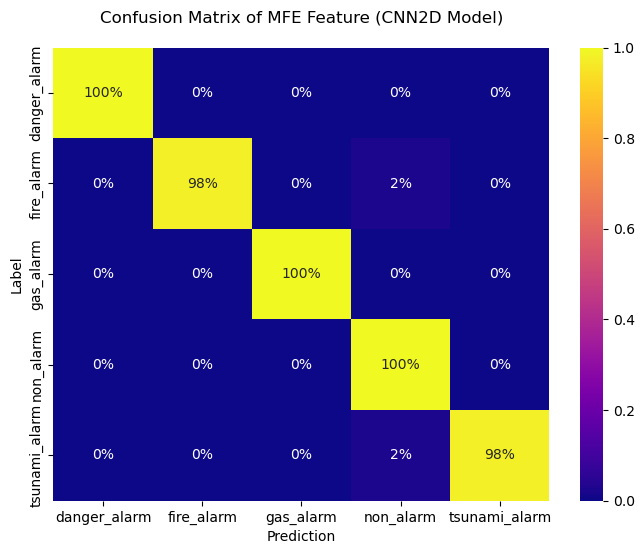

In [39]:
import seaborn as sns

# Labels from project
labels = ["danger_alarm", "fire_alarm", "gas_alarm", "non_alarm", "tsunami_alarm"]

# Show confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
cm_normalized=np.round(confusion_mtx/np.sum(confusion_mtx,axis=1).reshape(-1,1),2)
plt.figure(figsize=[8,6], dpi=100)
sns.heatmap(cm_normalized,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt=".0%", cmap="plasma")
plt.title("Confusion Matrix of MFE Feature (CNN2D Model)\n")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [40]:
from sklearn import metrics
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      0.98      0.99       185
           2       1.00      1.00      1.00       136
           3       0.98      1.00      0.99       238
           4       1.00      0.98      0.99       165

    accuracy                           0.99       890
   macro avg       1.00      0.99      0.99       890
weighted avg       0.99      0.99      0.99       890



## Train Using RNN-LSTM

In [41]:
LSTM_model = Sequential([
    Reshape((int(input_length / 40), 40), input_shape=(input_length, )),
    LSTM(128, return_sequences=True, input_shape=(input_length, 1)),
    Dropout(0.25),
    LSTM(64, return_sequences=False),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(classes, activation='softmax')
])
# this controls the learning rate
opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)

LSTM_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
LSTM_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 61, 40)            0         
                                                                 
 lstm (LSTM)                 (None, 61, 128)           86528     
                                                                 
 dropout_4 (Dropout)         (None, 61, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_6 (Dropout)         (None, 32)               

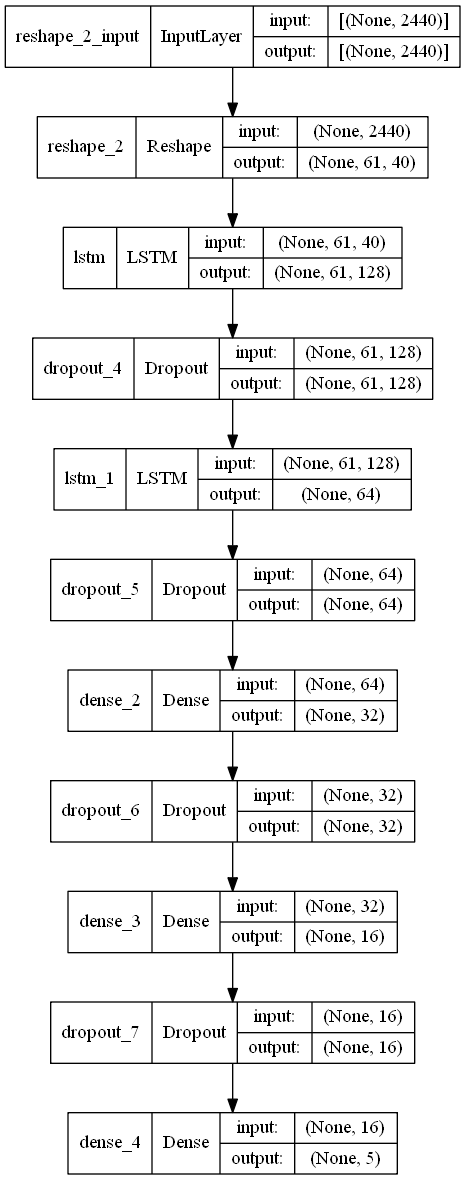

In [42]:
#plot model deep learning
plot_model(LSTM_model, to_file="model/model-LSTM-architecture.png", show_shapes=True)

In [43]:
filename='log/log_mfe_RNN-LSTM.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [44]:
from datetime import datetime
t0 = time.time() 
start = datetime.now()
# Train the model
# history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64)
history_RNN = LSTM_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=200, callbacks=[history_logger])
#history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset, verbose=2, callbacks=callbacks)

duration = datetime.now() - start
train_hist_m3 = pd.DataFrame(history_RNN.history)
train_m3 = round(time.time() - t0, 3)
print("Training completed in time: ", duration)

Epoch 1/200
112/112 [==============================] - 14s 94ms/step - loss: 1.5859 - accuracy: 0.2871 - val_loss: 1.5449 - val_accuracy: 0.2708
Epoch 2/200
112/112 [==============================] - 9s 81ms/step - loss: 1.3877 - accuracy: 0.3625 - val_loss: 1.2414 - val_accuracy: 0.4045
Epoch 3/200
112/112 [==============================] - 9s 82ms/step - loss: 1.2514 - accuracy: 0.4066 - val_loss: 1.1043 - val_accuracy: 0.4416
Epoch 4/200
112/112 [==============================] - 9s 82ms/step - loss: 1.1814 - accuracy: 0.4471 - val_loss: 1.1230 - val_accuracy: 0.4449
Epoch 5/200
112/112 [==============================] - 9s 81ms/step - loss: 1.1191 - accuracy: 0.4896 - val_loss: 1.0556 - val_accuracy: 0.5270
Epoch 6/200
112/112 [==============================] - 9s 82ms/step - loss: 1.0756 - accuracy: 0.5163 - val_loss: 0.9359 - val_accuracy: 0.5674
Epoch 7/200
112/112 [==============================] - 9s 82ms/step - loss: 0.9697 - accuracy: 0.5492 - val_loss: 1.1813 - val_accuracy

In [45]:
LSTM_model.save("model/RNN_mfe_model2.h5")
print("RNN-LSTM Model Saved")

RNN-LSTM Model Saved


In [46]:
acc_m3 = LSTM_model.evaluate(X_test, Y_test, verbose=0)
t0 = time.time()
y_pred_m3 = LSTM_model.predict(X_test, verbose=0)
pred_m3 = round(time.time() - t0, 3)
log_entry = pd.DataFrame(
    [["LSTM", acc_m3[1] * 100, train_m3, pred_m3]], columns=log_cols
)
log = log.append(log_entry)


In [47]:
log

,model,accuracy,train_time,pred_time
0,CNN1D,97.415727,157.810,0.269
0,CNN2D,99.325842,586.415,0.309
0,LSTM,96.179777,1771.054,1.285


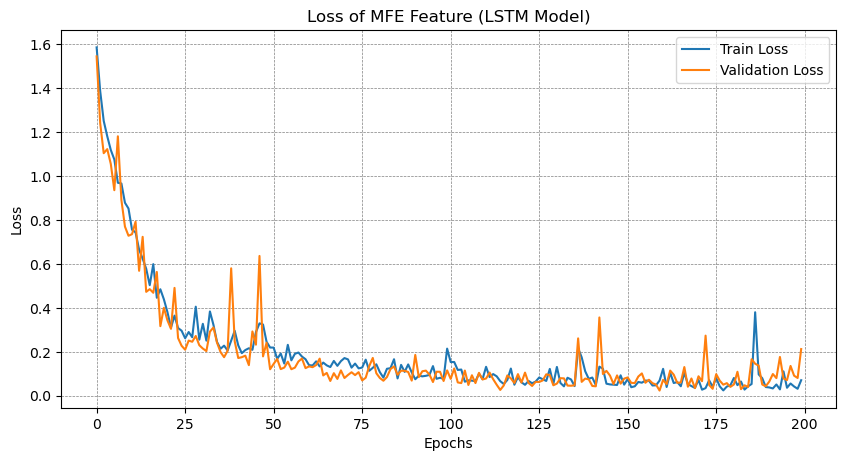

In [48]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_hist_m3[["loss", "val_loss"]])
plt.legend(["Train Loss", "Validation Loss"])
plt.title("Loss of MFE Feature (LSTM Model)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()

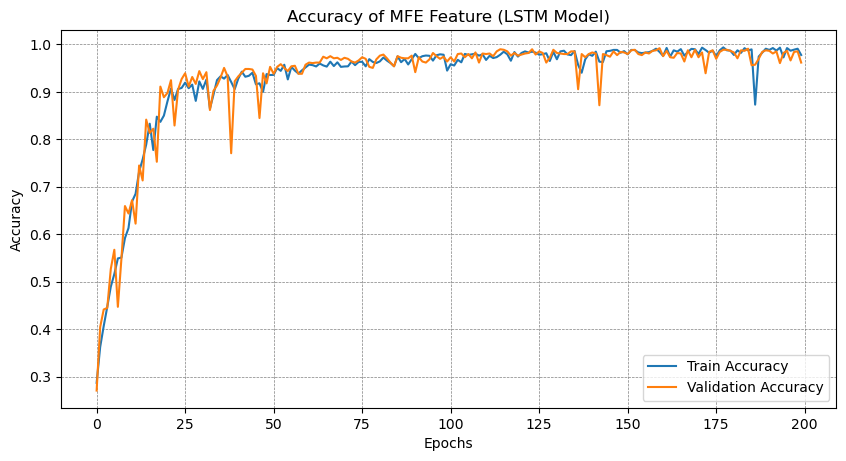

In [49]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_hist_m3[["accuracy", "val_accuracy"]])
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.title("Accuracy of MFE Feature (LSTM Model)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()

In [50]:
# train Accuracy and Loss
train_loss, train_acc = LSTM_model.evaluate(X_train, Y_train, verbose=0)
print("train loss: {0:.6f}, train accuracy: {1:.6f}".format(train_loss, train_acc))

# Val Accuracy and Loss
val_loss, val_acc = LSTM_model.evaluate(X_test, Y_test, verbose=0)
print("val loss: {0:.6f}, val accuracy: {1:.6f}".format(val_loss, val_acc))

train loss: 0.105211, train accuracy: 0.970754
val loss: 0.212871, val accuracy: 0.961798


In [51]:
from sklearn.metrics import confusion_matrix
predict_x=LSTM_model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

y_pred = LSTM_model.predict(X_test)
y_test_class = np.argmax(Y_test, axis=1)
cf_matrix = confusion_matrix(y_test_class, classes_x)
print (cf_matrix)

[[163   0   0   3   0]
 [  2 183   0   0   0]
 [  0   0 135   1   0]
 [  1   7   0 230   0]
 [  1  12   0   7 145]]


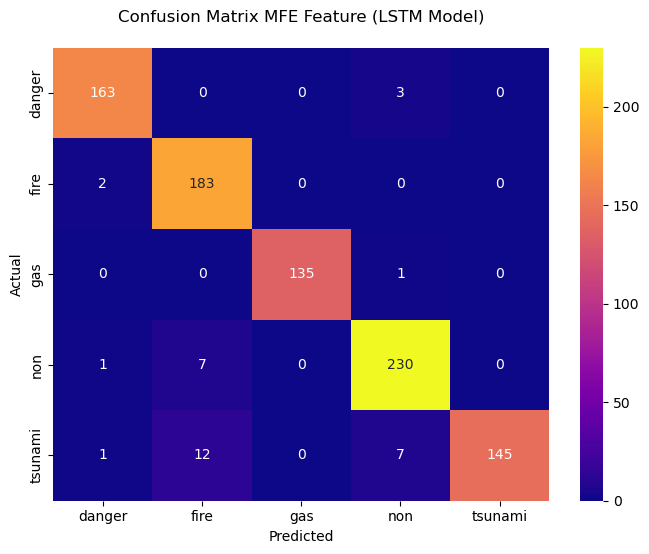

In [52]:
plt.figure(figsize=[8,6], dpi=100)
#confusion matrix prediction of validation data
ax = sns.heatmap(cf_matrix, annot=True, fmt=".0f", cmap='plasma')

ax.set_title('Confusion Matrix MFE Feature (LSTM Model)\n');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['danger','fire', 'gas', 'non','tsunami'])
ax.yaxis.set_ticklabels(['danger','fire', 'gas', 'non','tsunami'])
## Display the visualization of the Confusion Matrix.

plt.show()

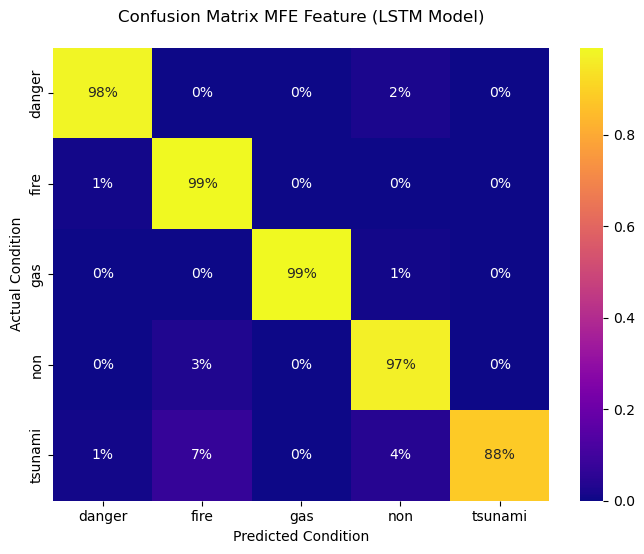

In [53]:
plt.figure(figsize=[8,6], dpi=100)
#confusion matrix prediction of validation data
cm_normalized=np.round(cf_matrix/np.sum(cf_matrix,axis=1).reshape(-1,1),2)
ax = sns.heatmap(cm_normalized, annot=True, fmt=".0%", cmap='plasma')

ax.set_title('Confusion Matrix MFE Feature (LSTM Model)\n');
ax.set_xlabel('Predicted Condition')
ax.set_ylabel('Actual Condition');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['danger','fire', 'gas', 'non','tsunami'])
ax.yaxis.set_ticklabels(['danger','fire', 'gas', 'non','tsunami'])
## Display the visualization of the Confusion Matrix.

plt.show()

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test_class, classes_x))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       166
           1       0.91      0.99      0.95       185
           2       1.00      0.99      1.00       136
           3       0.95      0.97      0.96       238
           4       1.00      0.88      0.94       165

    accuracy                           0.96       890
   macro avg       0.97      0.96      0.96       890
weighted avg       0.96      0.96      0.96       890



## Comparative Analysis

In [55]:
plt.rcParams["figure.figsize"] = (17, 2)
plt.rcParams["figure.dpi"] = 550

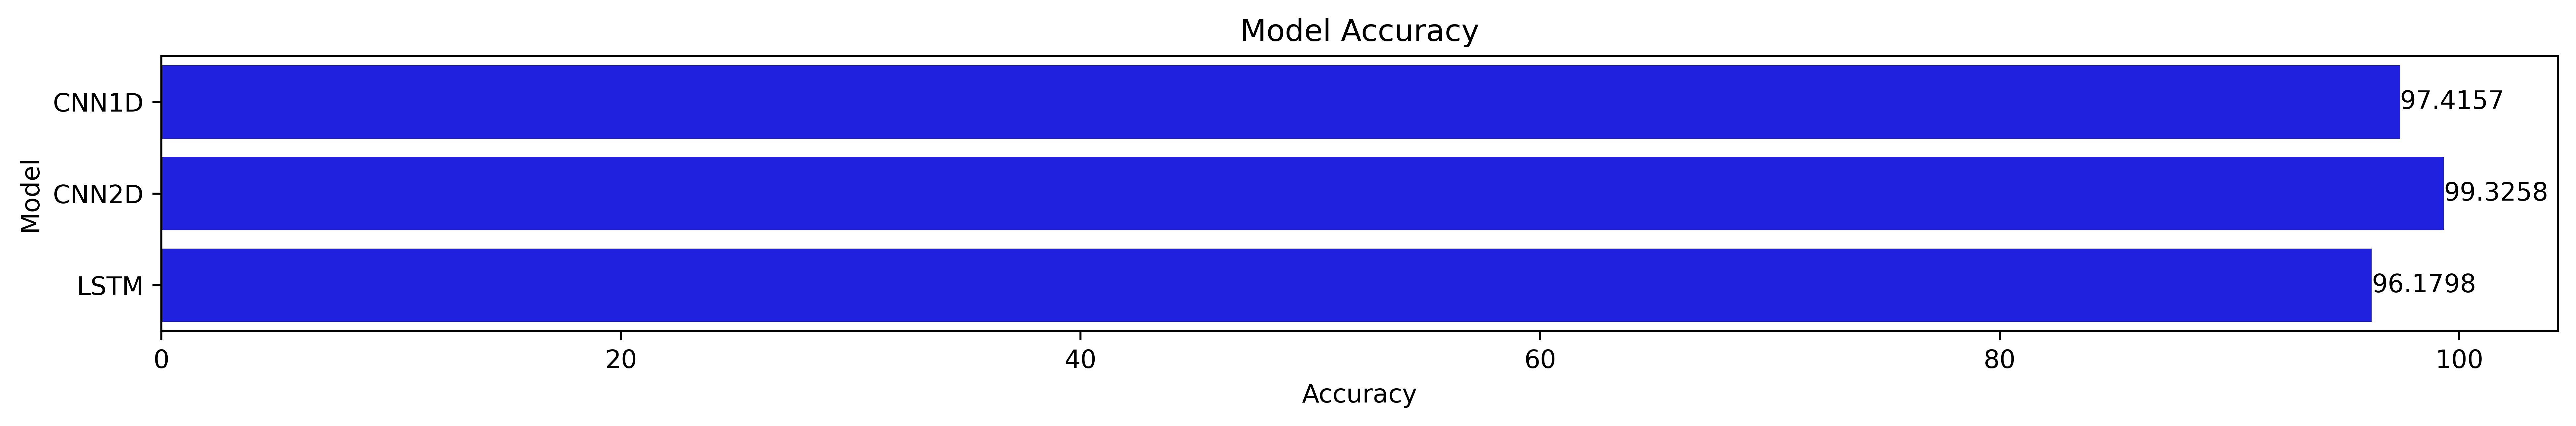

In [56]:
ax = sns.barplot(x="accuracy", y="model", data=log, color="b")
ax.bar_label(ax.containers[0])
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Model Accuracy")
plt.show()

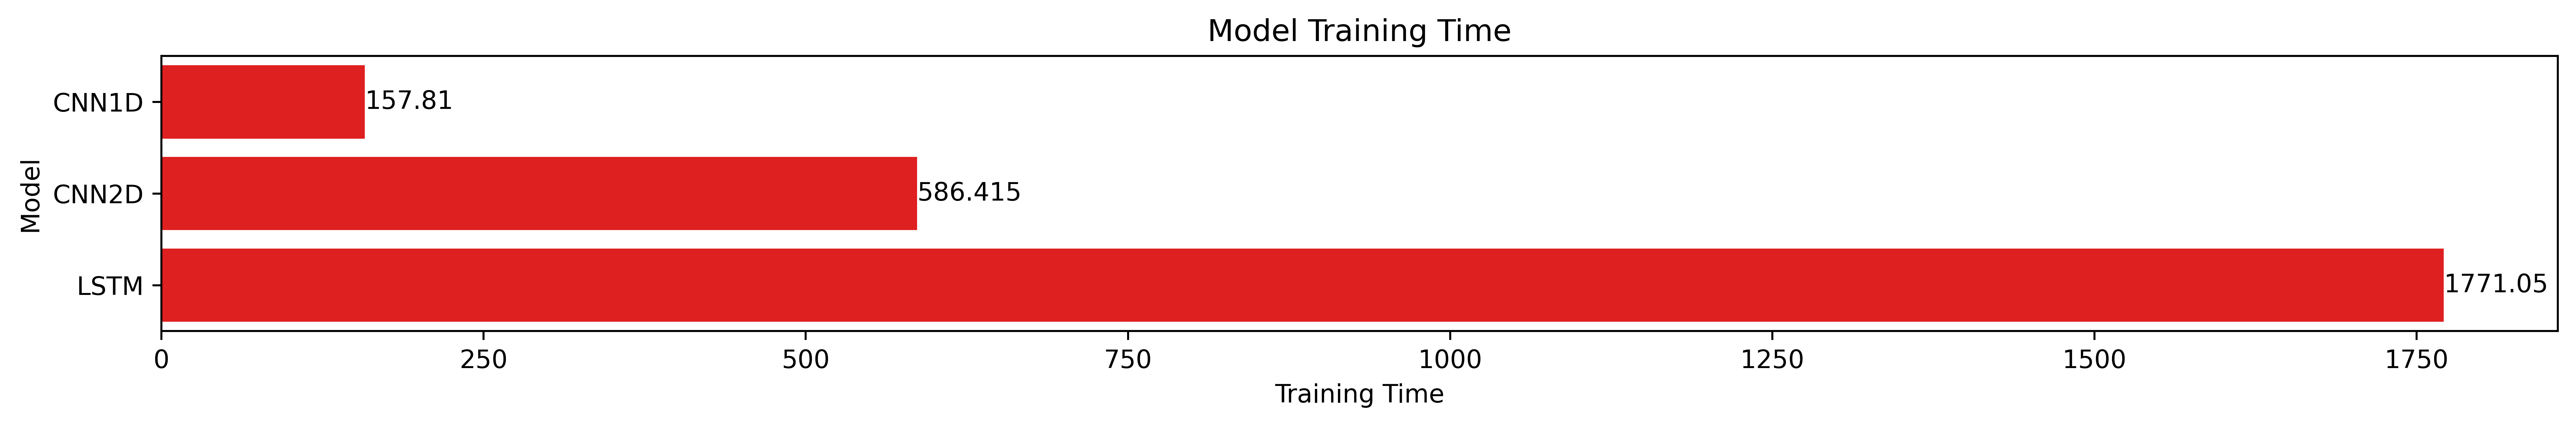

In [57]:
ax = sns.barplot(x="train_time", y="model", data=log, color="r")
ax.bar_label(ax.containers[0])
plt.xlabel("Training Time")
plt.ylabel("Model")
plt.title("Model Training Time")
plt.show()

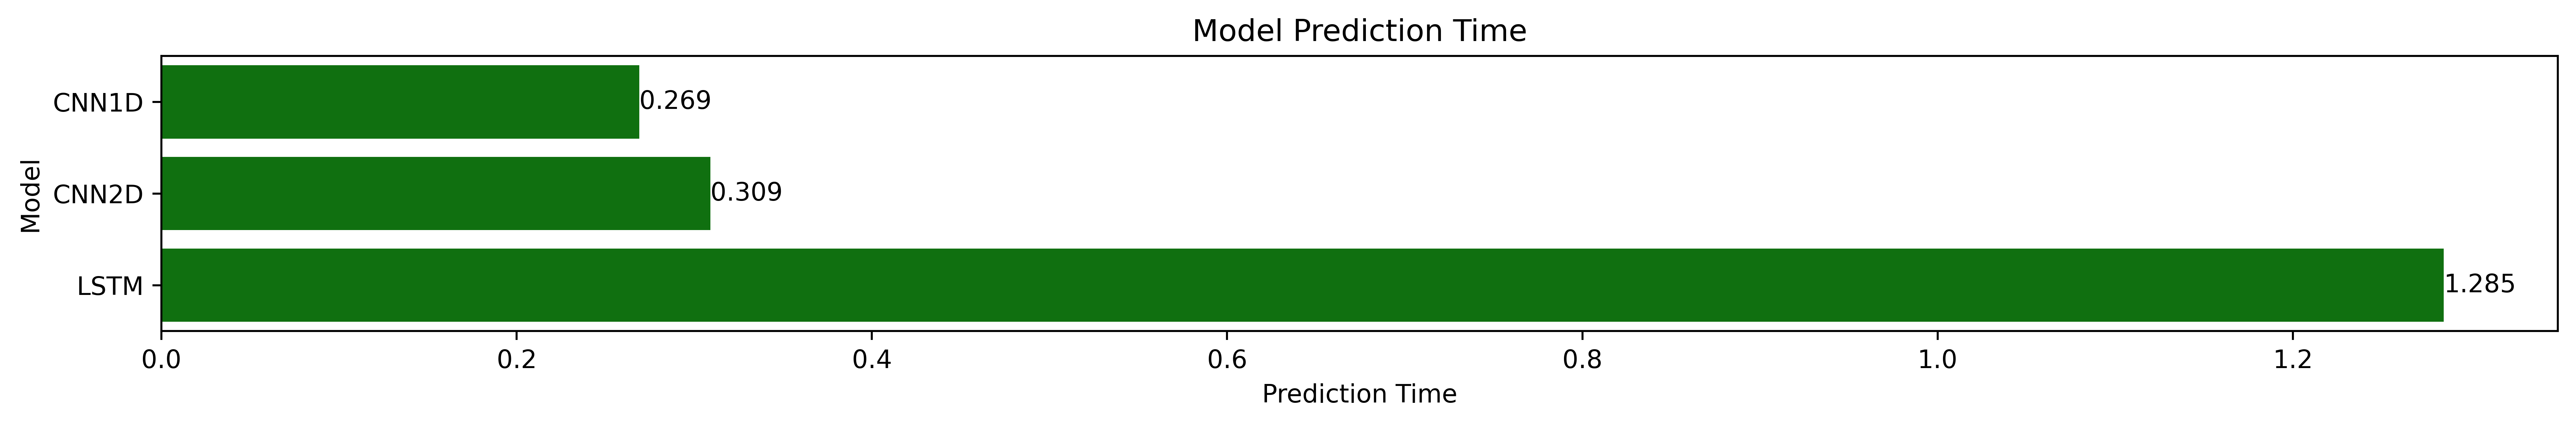

In [58]:
ax = sns.barplot(x="pred_time", y="model", data=log, color="g")
ax.bar_label(ax.containers[0])
plt.xlabel("Prediction Time")
plt.ylabel("Model")
plt.title("Model Prediction Time")
plt.show()

## Model performance with testing dataset

In [70]:
API_KEY = 'ei_6a1abea76edeb546b223590399e75ecd3449aee7450344d2351413c89e8f2ddd'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/109580/training/5/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/109580/training/5/y')

In [71]:
with open('dataset/x_test_data.npy', 'wb') as file:
    file.write(X)
with open('dataset/y_test_data.npy', 'wb') as file:
    file.write(Y)

In [72]:
X_testing = np.load('dataset/x_test_data.npy')
Y_testing = np.load('dataset/y_test_data.npy')[:,0]

In [73]:
Y_testing = tf.keras.utils.to_categorical(Y_testing - 1, classes)

input_length = X_testing[0].shape[0]

test_dataset = tf.data.Dataset.from_tensor_slices((X_testing, Y_testing))

In [74]:
testing_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=False)

In [75]:
from sklearn.metrics import confusion_matrix
predict_x=CNN2D_model.predict(X_testing) 
classes_x=np.argmax(predict_x,axis=1)

y_pred = CNN2D_model.predict(X_testing)
y_test_class = np.argmax(Y_testing, axis=1)
cf_matrix = confusion_matrix(y_test_class, classes_x)
print (cf_matrix)

[[59  0  0  1  0]
 [ 0 59  0  1  0]
 [ 0  0 58  2  0]
 [ 0  0  0 60  0]
 [ 0  0  0  1 59]]


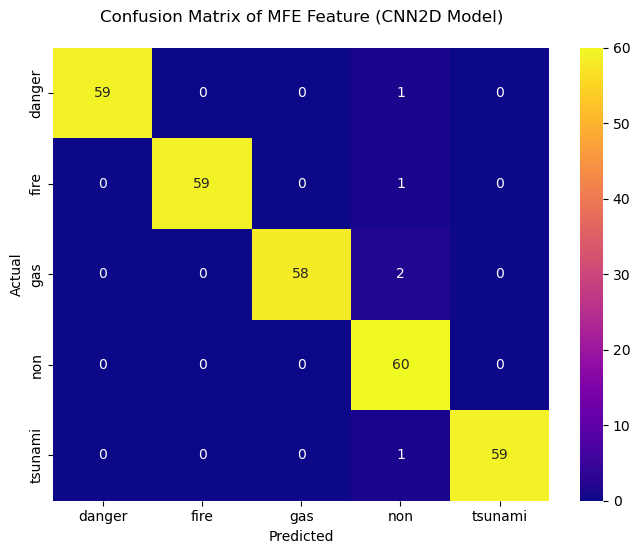

In [76]:
import seaborn as sns

plt.figure(figsize=[8,6], dpi=100)
#confusion matrix prediction of validation data
ax = sns.heatmap(cf_matrix, annot=True, fmt=".0f", cmap='plasma')

# normalized matriks
#cm_normalized=np.round(cf_matrix/np.sum(cf_matrix,axis=1).reshape(-1,1),2)
#ax = sns.heatmap(cm_normalized, annot=True, fmt=".0%", cmap='plasma')

plt.title("Confusion Matrix of MFE Feature (CNN2D Model)\n")
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['danger','fire', 'gas', 'non','tsunami'])
ax.yaxis.set_ticklabels(['danger','fire', 'gas', 'non','tsunami'])
## Display the visualization of the Confusion Matrix.

plt.show()

In [77]:
val_loss, val_acc = CNN2D_model.evaluate(testing_dataset, verbose=0)
print("model loss: {0:.2f}, model accuracy: {1:.2f}%".format(val_loss, val_acc*100))

model loss: 0.31, model accuracy: 98.33%


In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_test_class, classes_x))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       1.00      0.98      0.99        60
           2       1.00      0.97      0.98        60
           3       0.92      1.00      0.96        60
           4       1.00      0.98      0.99        60

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300

